# Overview
This notebook documents the initial preprocessing of the dataset and training of a logistical regression model to establish a baseline for our analysis. Excluding the target, there are a total of 13 features. Most of them are categorical and missing values to varying degrees.

In [1]:
# Import dependencies.
import pandas as pd
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
# Read in the data.
df = pd.read_csv('aug_train.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 14 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   enrollee_id             19158 non-null  int64  
 1   city                    19158 non-null  object 
 2   city_development_index  19158 non-null  float64
 3   gender                  14650 non-null  object 
 4   relevent_experience     19158 non-null  object 
 5   enrolled_university     18772 non-null  object 
 6   education_level         18698 non-null  object 
 7   major_discipline        16345 non-null  object 
 8   experience              19093 non-null  object 
 9   company_size            13220 non-null  object 
 10  company_type            13018 non-null  object 
 11  last_new_job            18735 non-null  object 
 12  training_hours          19158 non-null  int64  
 13  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(10)
me

In [3]:
# Summarize the features with missing values.
df.isnull().sum()[df.isnull().sum() != 0]

gender                 4508
enrolled_university     386
education_level         460
major_discipline       2813
experience               65
company_size           5938
company_type           6140
last_new_job            423
dtype: int64

# Features
Data transformation, including filling in missing values, for each feature is looked at individually.

## 0. `enrollee_id`
`enrollee_id` is used to identify those enrolled in the program. Since it is unique for each record and has no bearing on the target, it can be dropped.

In [4]:
df.enrollee_id.nunique()

19158

In [5]:
df.drop(columns='enrollee_id', inplace=True)

## 1. `city`
`city` with low counts can be binned together to reduce the total number of categories.

In [6]:
df.city.value_counts(dropna=False).head(20)

city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
city_136     586
city_67      431
city_75      305
city_102     304
city_104     301
city_73      280
city_100     275
city_71      266
city_11      247
city_90      197
city_61      197
city_28      192
city_23      182
city_65      175
city_36      160
Name: city, dtype: int64

In [7]:
# Create a bin for cities with fewer than `threshold` instances.
threshold = 200
city_counts = df['city'].value_counts()
cities_to_replace = city_counts[city_counts<threshold].index

for city in cities_to_replace:
    df['city'] = df['city'].replace(city, 'Other')

df['city'].value_counts(dropna=False)

Other       5392
city_103    4355
city_21     2702
city_16     1533
city_114    1336
city_160     845
city_136     586
city_67      431
city_75      305
city_102     304
city_104     301
city_73      280
city_100     275
city_71      266
city_11      247
Name: city, dtype: int64

## 2. `city_development_index`
This is one of the two numerical features in the dataset, and it is already scaled. If the `city` values are kept, it can be confirmed that each city has a single `city_development_index`, but different cities might share the same value: `all(df.groupby('city')['city_development_index'].nunique() == 1)` returns `True`.

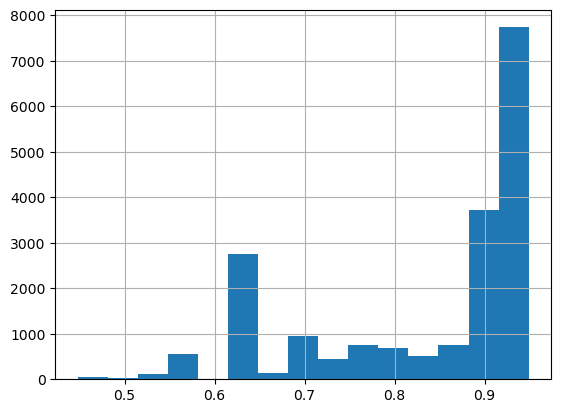

In [8]:
# Create a histogram for `city_development_index`.
df['city_development_index'].hist(bins=15);

## 3. `gender`
Missing values need to be dealt with. It's not immediately clear how to go about it: do we impute with the most frequent value to simply group it with `Other`? Since there are 10 males to 1 female in this training problem, we can approach this problem with filling in the missing values with the most frequent value of the feature, i.e., `Male`. The same approach is used for the other categorical features unless otherwise stated.

In [9]:
df['gender'].value_counts(dropna=False)

Male      13221
NaN        4508
Female     1238
Other       191
Name: gender, dtype: int64

In [10]:
df['gender'].fillna('Male', inplace=True)
df['gender'].value_counts(dropna=False)

Male      17729
Female     1238
Other       191
Name: gender, dtype: int64

## 4. `relevent_experience`
This is one of the few categorical features without missing values. Since it refers to the individual having or not having relevant experience, and it can be converted to `1`'s and `0`'s.

In [11]:
df['relevent_experience'].value_counts(dropna=False)

Has relevent experience    13792
No relevent experience      5366
Name: relevent_experience, dtype: int64

In [12]:
df['relevent_experience'].replace('Has relevent experience', 1, inplace=True)
df['relevent_experience'].replace('No relevent experience', 0, inplace=True)
df['relevent_experience'].value_counts(dropna=False)

1    13792
0     5366
Name: relevent_experience, dtype: int64

## 5. `enrolled_university`
Missing values are imputed with the most frequent value.

In [13]:
df['enrolled_university'].value_counts(dropna=False)

no_enrollment       13817
Full time course     3757
Part time course     1198
NaN                   386
Name: enrolled_university, dtype: int64

In [14]:
df['enrolled_university'].fillna('no_enrollment', inplace=True)
df['enrolled_university'].replace('no_enrollment', 'none', inplace=True)
df['enrolled_university'].replace('Full time course', 'full-time', inplace=True)
df['enrolled_university'].replace('Part time course', 'part-time', inplace=True)
df['enrolled_university'].value_counts(dropna=False)

none         14203
full-time     3757
part-time     1198
Name: enrolled_university, dtype: int64

## 6. `education_level`
Missing values are imputed with the most frequent value.

In [15]:
df['education_level'].value_counts(dropna=False)

Graduate          11598
Masters            4361
High School        2017
NaN                 460
Phd                 414
Primary School      308
Name: education_level, dtype: int64

In [16]:
df['education_level'].fillna('Graduate', inplace=True)
df['education_level'].value_counts(dropna=False)

Graduate          12058
Masters            4361
High School        2017
Phd                 414
Primary School      308
Name: education_level, dtype: int64

## 7. `major_discipline`
Missing values are imputed with the most frequent value. STEM stands for science, technology, engineering and mathematics.

In [17]:
df['major_discipline'].value_counts(dropna=False)

STEM               14492
NaN                 2813
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

In [18]:
df['major_discipline'].fillna('STEM', inplace=True)
df['major_discipline'].value_counts(dropna=False)

STEM               17305
Humanities           669
Other                381
Business Degree      327
Arts                 253
No Major             223
Name: major_discipline, dtype: int64

## 8. `experience`
Missing values for candidate's total experience in years are imputed with the most frequent value.

In [19]:
df['experience'].value_counts(dropna=False)

>20    3286
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
NaN      65
Name: experience, dtype: int64

In [20]:
df['experience'].fillna('>20', inplace=True)
df['experience'].value_counts(dropna=False)

>20    3351
5      1430
4      1403
3      1354
6      1216
2      1127
7      1028
10      985
9       980
8       802
15      686
11      664
14      586
1       549
<1      522
16      508
12      494
13      399
17      342
19      304
18      280
20      148
Name: experience, dtype: int64

In [21]:
# Create bins for boarder categorization of experience.
for exp in ['<1', '1', '2']:
    df['experience'].replace(exp, '0-2', inplace=True)
for exp in ['3', '4']:
    df['experience'].replace(exp, '3-4', inplace=True)
for exp in ['5', '6', '7', '8', '9']:
    df['experience'].replace(exp, '5-9', inplace=True)
for exp in ['10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '>20']:
    df['experience'].replace(exp, '>=10', inplace=True)

df['experience'].value_counts(dropna=False)

>=10    8747
5-9     5456
3-4     2757
0-2     2198
Name: experience, dtype: int64

## 9. `company_size`
Missing values for the company size are imputed with the most frequent value.

In [22]:
df['company_size'].value_counts(dropna=False)

NaN          5938
50-99        3083
100-500      2571
10000+       2019
10/49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

In [23]:
df['company_size'].replace('10/49', '10-49', inplace=True)
df['company_size'].replace('10000+', '>10000', inplace=True)
df['company_size'].fillna('50-99', inplace=True)
df['company_size'].value_counts(dropna=False)

50-99        9021
100-500      2571
>10000       2019
10-49        1471
1000-4999    1328
<10          1308
500-999       877
5000-9999     563
Name: company_size, dtype: int64

## 10. `company_type`
Missing values for the company type are imputed with the most frequent value.

In [24]:
df['company_type'].value_counts(dropna=False)

Pvt Ltd                9817
NaN                    6140
Funded Startup         1001
Public Sector           955
Early Stage Startup     603
NGO                     521
Other                   121
Name: company_type, dtype: int64

In [25]:
df['company_type'].fillna('Pvt Ltd', inplace=True)
df['company_type'].value_counts(dropna=False)

Pvt Ltd                15957
Funded Startup          1001
Public Sector            955
Early Stage Startup      603
NGO                      521
Other                    121
Name: company_type, dtype: int64

## 11. `last_new_job`
Missing values for difference in years between previous and current job are imputed with the most frequent value.

In [26]:
df['last_new_job'].value_counts(dropna=False)

1        8040
>4       3290
2        2900
never    2452
4        1029
3        1024
NaN       423
Name: last_new_job, dtype: int64

In [27]:
df['last_new_job'].fillna('1', inplace=True)
df['last_new_job'].value_counts(dropna=False)

1        8463
>4       3290
2        2900
never    2452
4        1029
3        1024
Name: last_new_job, dtype: int64

## 12. `training_hours`

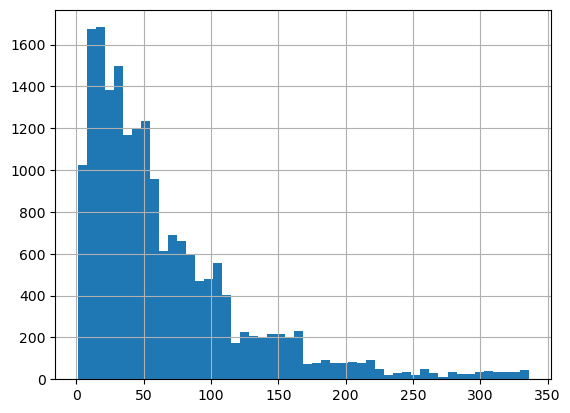

In [28]:
df['training_hours'].hist(bins=50);

## 13. `target`
`target` is imbalanced, so it needs to be addressed by ensuring `stratify=y` and/or resampling.

In [29]:
df['target'].value_counts(dropna=False)

0.0    14381
1.0     4777
Name: target, dtype: int64

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19158 entries, 0 to 19157
Data columns (total 13 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    19158 non-null  object 
 1   city_development_index  19158 non-null  float64
 2   gender                  19158 non-null  object 
 3   relevent_experience     19158 non-null  int64  
 4   enrolled_university     19158 non-null  object 
 5   education_level         19158 non-null  object 
 6   major_discipline        19158 non-null  object 
 7   experience              19158 non-null  object 
 8   company_size            19158 non-null  object 
 9   company_type            19158 non-null  object 
 10  last_new_job            19158 non-null  object 
 11  training_hours          19158 non-null  int64  
 12  target                  19158 non-null  float64
dtypes: float64(2), int64(2), object(9)
memory usage: 1.9+ MB


# Model Implementation

In [31]:
model_df = pd.get_dummies(df)
model_df.head()

,city_development_index,relevent_experience,training_hours,target,city_Other,city_city_100,city_city_102,city_city_103,city_city_104,city_city_11,...,company_type_NGO,company_type_Other,company_type_Public Sector,company_type_Pvt Ltd,last_new_job_1,last_new_job_2,last_new_job_3,last_new_job_4,last_new_job_>4,last_new_job_never
0,0.920,1,36,1.0,0,0,0,1,0,0,...,0,0,0,1,1,0,0,0,0,0
1,0.776,0,47,0.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,1,0
2,0.624,0,83,0.0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
3,0.789,0,52,1.0,1,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,1
4,0.767,1,8,0.0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [32]:
# Split the data into a training set and a testing set.
y = model_df.target
X = model_df.drop(columns='target')
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, stratify=y)

# Instantiate a StandardScaler instance.
scaler = StandardScaler()

# Fit the training data to the standard scaler.
X_scaler = scaler.fit(X_train)

# Transform the training data using the scaler.
X_train_scaled = X_scaler.transform(X_train)

# Transform the testing data using the scaler.
X_test_scaled = X_scaler.transform(X_test)

In [33]:
# Due to imbalanced target values, instantiate the random oversampler model.
ros = RandomOverSampler(random_state=42)
X_res, y_res = ros.fit_resample(X_train_scaled, y_train)

In [34]:
# Implement a logistic regression model.
classifier = LogisticRegression(solver='lbfgs', random_state=42)
classifier.fit(X_res, y_res)
predictions = classifier.predict(X_test_scaled)

In [35]:
# Display the accuracy score for the test dataset.
print(f'Accuracy score: {accuracy_score(y_test, predictions):.2f}')

Accuracy score: 0.74


In [36]:
# Display the confusion matrix.
confusion_matrix(y_test, predictions)

array([[2678,  918],
       [ 313,  881]], dtype=int64)

| n=19158 | Predicted: Staying | Predicted: Leaving |
| --- | --- | --- |
| Actual: Staying | 2678 | 918 |
| Actual: Leaving | 313 | 881 |


In [37]:
# Display the classification report.
target_names = ['stay', 'leave']
print(classification_report(y_test, predictions, target_names=target_names))

              precision    recall  f1-score   support

        stay       0.90      0.74      0.81      3596
       leave       0.49      0.74      0.59      1194

    accuracy                           0.74      4790
   macro avg       0.69      0.74      0.70      4790
weighted avg       0.79      0.74      0.76      4790



Considering that a recall score of 0.74 is achieved for predicting individuals leaving their current employment, this is a good starting point for our analysis.

# Feature Importance

In [38]:
importance = classifier.coef_[0]

In [39]:
for i,v in enumerate(importance):
    if abs(v)>=0.1:
        print(f'Feature: {X.columns[i]}, Score: {v:.3f}')

Feature: city_development_index, Score: -0.651
Feature: relevent_experience, Score: -0.232
Feature: city_Other, Score: -0.158
Feature: city_city_103, Score: 0.154
Feature: city_city_114, Score: -0.105
Feature: city_city_136, Score: -0.109
Feature: city_city_21, Score: 0.229
Feature: education_level_Graduate, Score: 0.117
Feature: education_level_High School, Score: -0.178
Feature: education_level_Primary School, Score: -0.119
Feature: company_size_100-500, Score: -0.125
Feature: company_size_50-99, Score: 0.270
Feature: company_type_Funded Startup, Score: -0.136
Feature: last_new_job_never, Score: -0.133


In [40]:
df[df['city']=='city_103']['city_development_index'].unique()[0]

0.92

In [41]:
df[df['city']=='city_114']['city_development_index'].unique()[0]

0.926

In [42]:
df[df['city']=='city_136']['city_development_index'].unique()[0]

0.897

In [43]:
df[df['city']=='city_21']['city_development_index'].unique()[0]

0.624

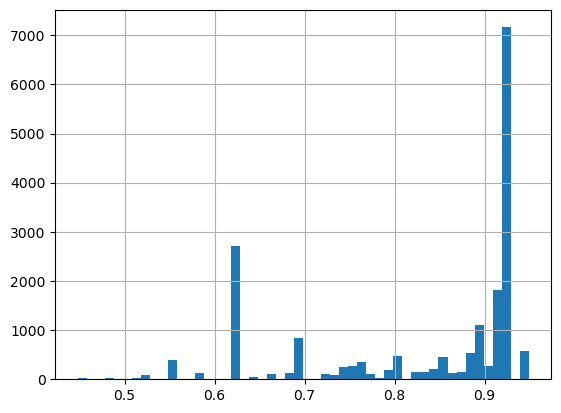

In [46]:
df['city_development_index'].hist(bins=50);

In [47]:
df['city_development_index'].describe()

count    19158.000000
mean         0.828848
std          0.123362
min          0.448000
25%          0.740000
50%          0.903000
75%          0.920000
max          0.949000
Name: city_development_index, dtype: float64

In [48]:
df[['city_development_index', 'target']].corr()

,city_development_index,target
city_development_index,1.000000,-0.341665
target,-0.341665,1.000000


In [45]:
# from sklearn.ensemble import RandomForestClassifier

# # Create the random forest classifier instance
# rf_model = RandomForestClassifier(n_estimators=500, random_state=42)
# rf_model = rf_model.fit(X_res, y_res)
# predictions = rf_model.predict(X_test_scaled)

# # Display the accuracy score for the test dataset.
# print(f'Accuracy score: {accuracy_score(y_test, predictions):.2f}')

# # Display the confusion matrix.
# confusion_matrix(y_test, predictions)

# # Display the classification report.
# target_names = ['stay', 'leave']
# print(classification_report(y_test, predictions, target_names=target_names))